# Define common imports and funtions

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import time
import numpy as np
import os

# Load Dataset

In [6]:
train_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

val_dataset_raw = tf.keras.utils.image_dataset_from_directory(
    'dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)
class_names = train_dataset_raw.class_names


Found 4134 files belonging to 5 classes.
Found 885 files belonging to 5 classes.


# Explore Dataset

In [7]:
import os

def count_images(base_dir):
    total_images = 0
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
            total_images += count
    return total_images, class_counts

train_total, train_classes = count_images("dataset/train")
val_total, val_classes = count_images("dataset/val")

print("Training set:")
print(f"Total images: {train_total}")
print(f"Class distribution: {train_classes}")

print("\nValidation set:")
print(f"Total images: {val_total}")
print(f"Class distribution: {val_classes}")


Training set:
Total images: 4134
Class distribution: {'maine_coon_cat': 926, 'persian_cat': 854, 'scottish_fold_cat': 883, 'siamese_cat': 746, 'sphynx_hairless_cat': 725}

Validation set:
Total images: 885
Class distribution: {'maine_coon_cat': 198, 'persian_cat': 183, 'scottish_fold_cat': 189, 'siamese_cat': 160, 'sphynx_hairless_cat': 155}


# Load Dataset and Visualize Sample Images

Found 4134 files belonging to 5 classes.
Classes: ['maine_coon_cat', 'persian_cat', 'scottish_fold_cat', 'siamese_cat', 'sphynx_hairless_cat']


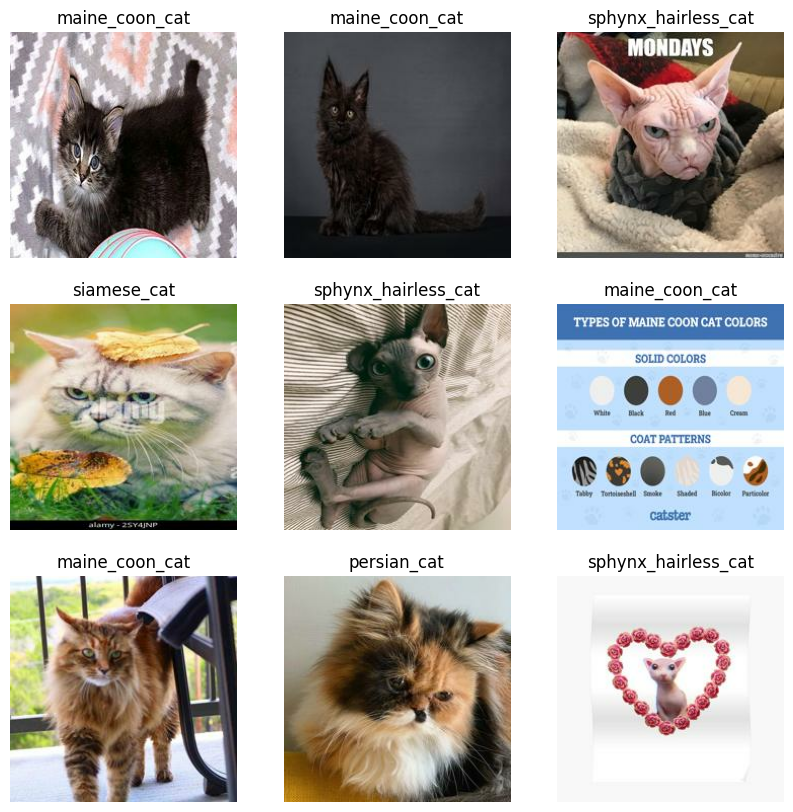

In [8]:
import matplotlib.pyplot as plt

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/train", image_size=(224, 224), batch_size=32
)

# View class names
class_names = train_dataset.class_names
print("Classes:", class_names)

# Show 9 sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Normalize Pixel Value

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset_raw.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset_raw.map(lambda x, y: (normalization_layer(x), y))


# Prefecthing

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


# Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


# Build Model Function

In [12]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Train and evaluate

In [22]:
def train_and_evaluate(model_name, base_model_class):
    print(f"\nTraining {model_name}...")
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Optional: fine-tune later

    model = build_model(base_model)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    start_time = time.time()
    history = model.fit(train_dataset, 
                        validation_data=val_dataset, 
                        epochs=50, verbose=2)
    total_time = time.time() - start_time

# Compute mAP manually (since it's not built-in)
    y_true, y_pred = [], []
    for images, labels in val_dataset:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())

    mAP = tf.keras.metrics.MeanMetricWrapper(
        tf.keras.metrics.AUC(curve='PR'), name='mean_average_precision'
    )
    mAP.update_state(tf.one_hot(y_true, depth=len(class_names)),
                     tf.one_hot(y_pred, depth=len(class_names)))
    
    print(f"{model_name} - Accuracy: {history.history['val_accuracy'][-1]:.4f}, mAP: {mAP.result().numpy():.4f}, Time: {total_time:.2f} sec")

    return {
        'model': model,
        'history': history,
        'accuracy': history.history['val_accuracy'][-1],
        'mAP': mAP.result().numpy(),
        'training_time': total_time
    }

In [23]:
resnet_results = train_and_evaluate("ResNet50", ResNet50)


Training ResNet50...
Epoch 1/50
130/130 - 45s - loss: 1.6103 - accuracy: 0.2291 - val_loss: 1.5715 - val_accuracy: 0.2814 - 45s/epoch - 346ms/step
Epoch 2/50
130/130 - 39s - loss: 1.5845 - accuracy: 0.2687 - val_loss: 1.5467 - val_accuracy: 0.3299 - 39s/epoch - 302ms/step
Epoch 3/50
130/130 - 39s - loss: 1.5633 - accuracy: 0.2857 - val_loss: 1.5336 - val_accuracy: 0.3107 - 39s/epoch - 297ms/step
Epoch 4/50
130/130 - 39s - loss: 1.5499 - accuracy: 0.2929 - val_loss: 1.5289 - val_accuracy: 0.3096 - 39s/epoch - 297ms/step
Epoch 5/50
130/130 - 39s - loss: 1.5461 - accuracy: 0.3004 - val_loss: 1.5243 - val_accuracy: 0.2994 - 39s/epoch - 299ms/step
Epoch 6/50
130/130 - 39s - loss: 1.5436 - accuracy: 0.3029 - val_loss: 1.5162 - val_accuracy: 0.3740 - 39s/epoch - 298ms/step
Epoch 7/50
130/130 - 39s - loss: 1.5371 - accuracy: 0.3050 - val_loss: 1.5052 - val_accuracy: 0.3390 - 39s/epoch - 299ms/step
Epoch 8/50
130/130 - 39s - loss: 1.5316 - accuracy: 0.3087 - val_loss: 1.5168 - val_accuracy: 0.

In [24]:
densenet_results = train_and_evaluate("DenseNet121", DenseNet121)


Training DenseNet121...
Epoch 1/50
130/130 - 60s - loss: 1.0537 - accuracy: 0.6030 - val_loss: 0.7718 - val_accuracy: 0.7186 - 60s/epoch - 459ms/step
Epoch 2/50
130/130 - 49s - loss: 0.7229 - accuracy: 0.7521 - val_loss: 0.6878 - val_accuracy: 0.7684 - 49s/epoch - 375ms/step
Epoch 3/50
130/130 - 49s - loss: 0.6720 - accuracy: 0.7663 - val_loss: 0.6581 - val_accuracy: 0.7684 - 49s/epoch - 377ms/step
Epoch 4/50
130/130 - 49s - loss: 0.6283 - accuracy: 0.7898 - val_loss: 0.6309 - val_accuracy: 0.7684 - 49s/epoch - 377ms/step
Epoch 5/50
130/130 - 49s - loss: 0.5944 - accuracy: 0.8000 - val_loss: 0.6096 - val_accuracy: 0.7797 - 49s/epoch - 378ms/step
Epoch 6/50
130/130 - 49s - loss: 0.5797 - accuracy: 0.8084 - val_loss: 0.5958 - val_accuracy: 0.7876 - 49s/epoch - 375ms/step
Epoch 7/50
130/130 - 49s - loss: 0.5628 - accuracy: 0.8137 - val_loss: 0.6041 - val_accuracy: 0.7808 - 49s/epoch - 377ms/step
Epoch 8/50
130/130 - 49s - loss: 0.5478 - accuracy: 0.8133 - val_loss: 0.5954 - val_accuracy:

In [25]:
mobilenet_results = train_and_evaluate("MobileNetV3Small", MobileNetV3Small)


Training MobileNetV3Small...
Epoch 1/50
130/130 - 32s - loss: 1.6090 - accuracy: 0.2063 - val_loss: 1.6064 - val_accuracy: 0.2136 - 32s/epoch - 244ms/step
Epoch 2/50
130/130 - 27s - loss: 1.6069 - accuracy: 0.2276 - val_loss: 1.6040 - val_accuracy: 0.2520 - 27s/epoch - 207ms/step
Epoch 3/50
130/130 - 28s - loss: 1.6060 - accuracy: 0.2291 - val_loss: 1.6009 - val_accuracy: 0.2271 - 28s/epoch - 218ms/step
Epoch 4/50
130/130 - 27s - loss: 1.6037 - accuracy: 0.2327 - val_loss: 1.6085 - val_accuracy: 0.2237 - 27s/epoch - 207ms/step
Epoch 5/50
130/130 - 27s - loss: 1.6005 - accuracy: 0.2254 - val_loss: 1.5978 - val_accuracy: 0.2599 - 27s/epoch - 209ms/step
Epoch 6/50
130/130 - 27s - loss: 1.5993 - accuracy: 0.2279 - val_loss: 1.5952 - val_accuracy: 0.2463 - 27s/epoch - 208ms/step
Epoch 7/50
130/130 - 28s - loss: 1.5967 - accuracy: 0.2254 - val_loss: 1.5946 - val_accuracy: 0.2215 - 28s/epoch - 217ms/step
Epoch 8/50
130/130 - 28s - loss: 1.5965 - accuracy: 0.2300 - val_loss: 1.5925 - val_accu

## Loss and Accuracy Plot

In [28]:
results = [
    {'name': 'ResNet50', **resnet_results},
    {'name': 'DenseNet121', **densenet_results},
    {'name': 'MobileNetV3Small', **mobilenet_results}
]


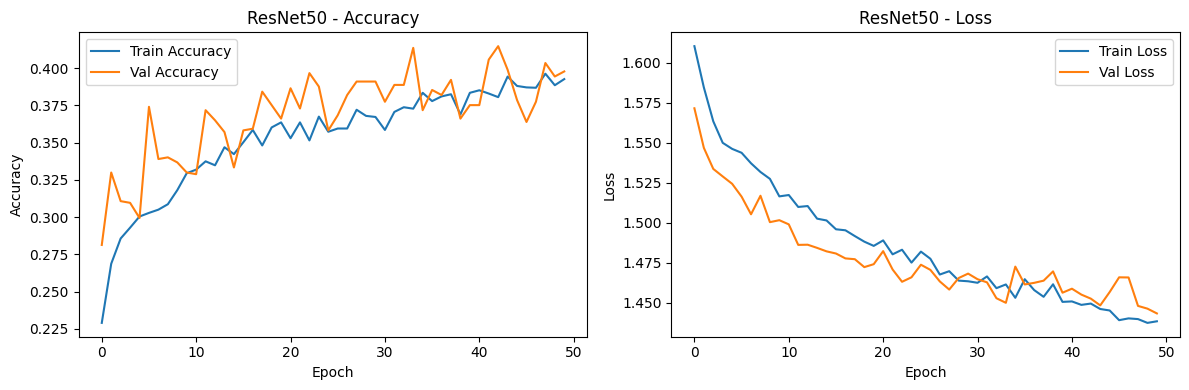

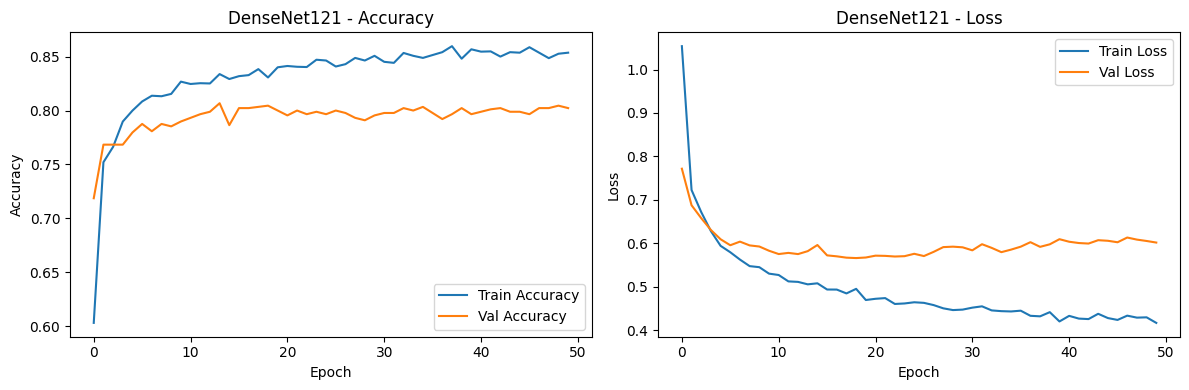

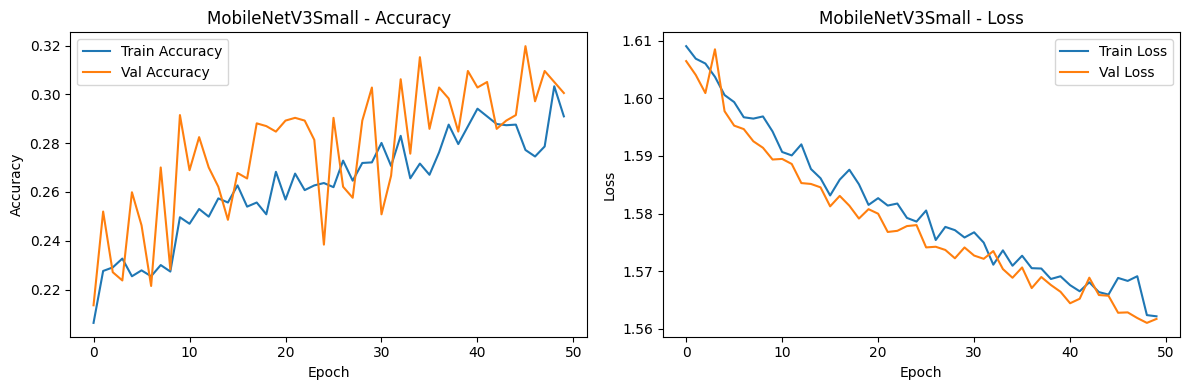

In [29]:
import matplotlib.pyplot as plt

for result in results:
    history = result['history']
    
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{result['name']} - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{result['name']} - Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Confusion Matrix

In [48]:
raw_test_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',           
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

class_names = raw_test_dataset.class_names


Found 890 files belonging to 5 classes.


In [47]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_dataset = raw_test_dataset.map(lambda x, y: (normalization_layer(x), y))


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names, title):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 349ms/step


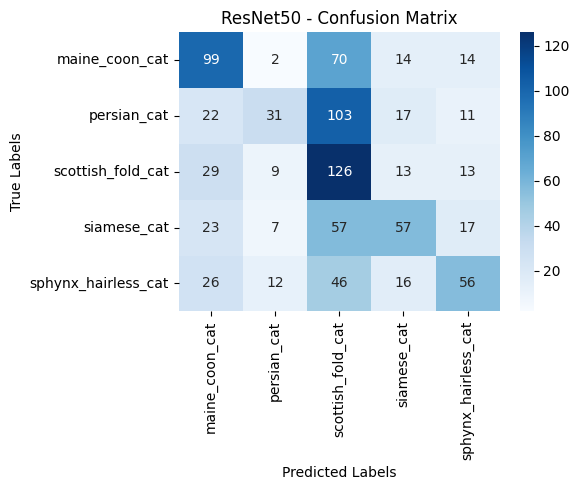

In [37]:
plot_confusion_matrix(resnet_results['model'], test_dataset, class_names, "ResNet50")


1/1 [==============================] - 0s 302ms/step


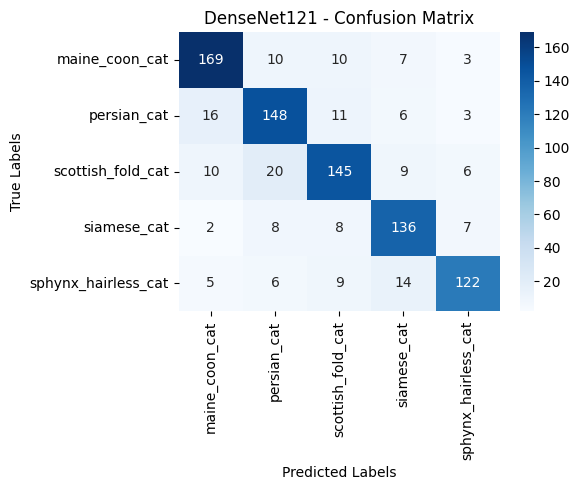

In [39]:
plot_confusion_matrix(densenet_results['model'], test_dataset, class_names, "DenseNet121")

1/1 [==============================] - 0s 56ms/step


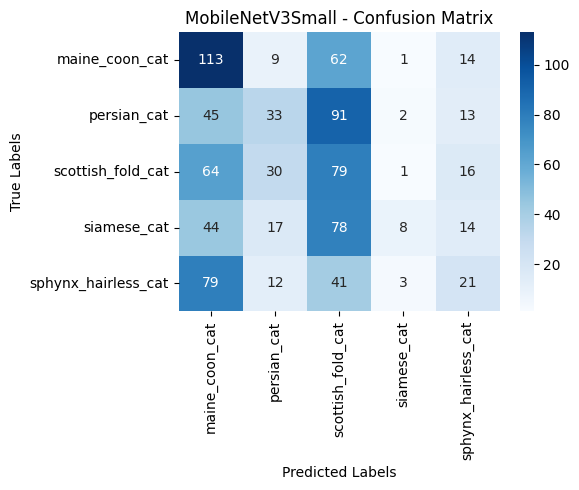

In [40]:
plot_confusion_matrix(mobilenet_results['model'], test_dataset, class_names, "MobileNetV3Small")

## Performance of the model againts testing dataset

In [41]:
for result in results:
    test_loss, test_acc = result['model'].evaluate(test_dataset)
    print(f"{result['name']} - Test Accuracy: {test_acc:.4f}")

28/28 [==============================] - 10s 327ms/step - loss: 1.4305 - accuracy: 0.4146
ResNet50 - Test Accuracy: 0.4146
28/28 [==============================] - 10s 343ms/step - loss: 0.6410 - accuracy: 0.8090
DenseNet121 - Test Accuracy: 0.8090
28/28 [==============================] - 1s 46ms/step - loss: 1.5610 - accuracy: 0.2854
MobileNetV3Small - Test Accuracy: 0.2854


## Comparison Table

In [45]:
import pandas as pd

resnet_results['name'] = "ResNet50"
densenet_results['name'] = "DenseNet121"
mobilenet_results['name'] = "MobileNetV3Small"

results = [resnet_results, densenet_results, mobilenet_results]

comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'Validation Accuracy': round(r['accuracy'], 4),
    'mAP': round(r['mAP'], 4),
    'Training Time (sec)': round(r['training_time'], 2),
    'Parameters (Millions)': round(r['model'].count_params() / 1e6, 2)
} for r in results])

print(comparison_df)

              Model  Validation Accuracy     mAP  Training Time (sec)  \
0          ResNet50               0.3977  0.3088              2044.88   
1       DenseNet121               0.8023  0.7133              2572.76   
2  MobileNetV3Small               0.3006  0.2474              1422.96   

   Parameters (Millions)  
0                  23.60  
1                   7.04  
2                   0.94  


## FINAL CONCLUSION


After training and evaluating all three CNN models, the results show a clear distinction in performance:

DenseNet121 significantly outperformed the others in both accuracy (80.23%) and mean average precision (71.33%), making it the most reliable model for this classification task. Though it had the longest training time (~42 minutes), the improvement in predictive performance justifies the additional time.

ResNet50, despite being a powerful architecture, underperformed with only 39.77% accuracy and a mAP of 30.88%. This suggests that it may not generalize well to your dataset in its current configuration.

MobileNetV3Small, while the fastest to train (~24 minutes), yielded the lowest results across all metrics (30.06% accuracy, 24.74% mAP). It may be suitable for mobile applications where speed is critical, but not for accurate classification.

DenseNet121 is the best suited model for your classification task. It offers strong accuracy and precision, making it ideal despite the longer training time.